# Machine Learning: Assignment 3

Name:  Hunter Reilly<br />
Class: Machine Learning (CSCI 191T)<br />
Due:   4/4/18<br />
Group: 4Loop<br />
<br />
For this notebook, I used the CNN modeling approach using Keras, outlined in many of the Digit Recognizer kernals.

## Imports
We start with the basic imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')


Using TensorFlow backend.


## Getting the MNIST Dataset
Next, we aquire the data files needed to run our analysis

In [2]:
# getting the data
train = pd.read_csv("MNISTInput/train.csv")
test = pd.read_csv("MNISTInput/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

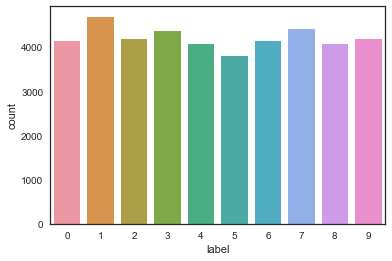

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

Here we see that there are a similar amount of characters.

## Checking for Null Values or Missing Values

In [4]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## Normalizing the Data
By normalizing the data to a greyscale, it removes certain illumination differences

In [6]:
X_train = X_train / 255.0
test = test / 255.0

## Reshape Images
Reshaping the images to 3D allows the use of Keras, because Keras requires a 3rd dimension

In [7]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## One Hot Encoding Labels
This is done to make it easier to run the data through the model

In [8]:
Y_train = to_categorical(Y_train, num_classes = 10)

## Spliting the Train Into Two Parts
10% of the data is evalutaed while 90% is used to train the model

In [9]:
random_seed = 2

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

## The CNN Model

In [11]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## Optimizing the Model
For the optimization, RMSprop is used, as it a very effective optimizer

In [12]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

Now, we compile the model

In [13]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Setting a learning rate annealer

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [15]:
epochs = 1 # higher epoch equals a higher accuracy, but a much longer processing time
batch_size = 86

## Augementation of Data

In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Fitting the Training Data
This takes the longest time to process

In [18]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 165s - loss: 0.4036 - acc: 0.8710 - val_loss: 0.0879 - val_acc: 0.9743


## Getting the Results
Now we get the results and export the .csv file

In [22]:
results = model.predict(test)

results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [23]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("MNISTOutput.csv",index=False)